## Image Classification with Transfer Learning

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure File Locations

# dataset labels
labels = pd.read_csv('labels.csv')

# folders paths
train_path = 'train'
test_path = 'test'


In [3]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# Add .jpg extension to id to map to file names

def to_jpg(id):
    return id+".jpg"


labels['id'] = labels['id'].apply(to_jpg)

## The next 3 cells run a data aumentation process to modify the original images for tranfer learning

In [5]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )

In [6]:
train_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 8178 validated image filenames belonging to 120 classes.


In [7]:
validation_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="validation",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 2044 validated image filenames belonging to 120 classes.


In [8]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 331, 331, 3)

## Display a batch of training images

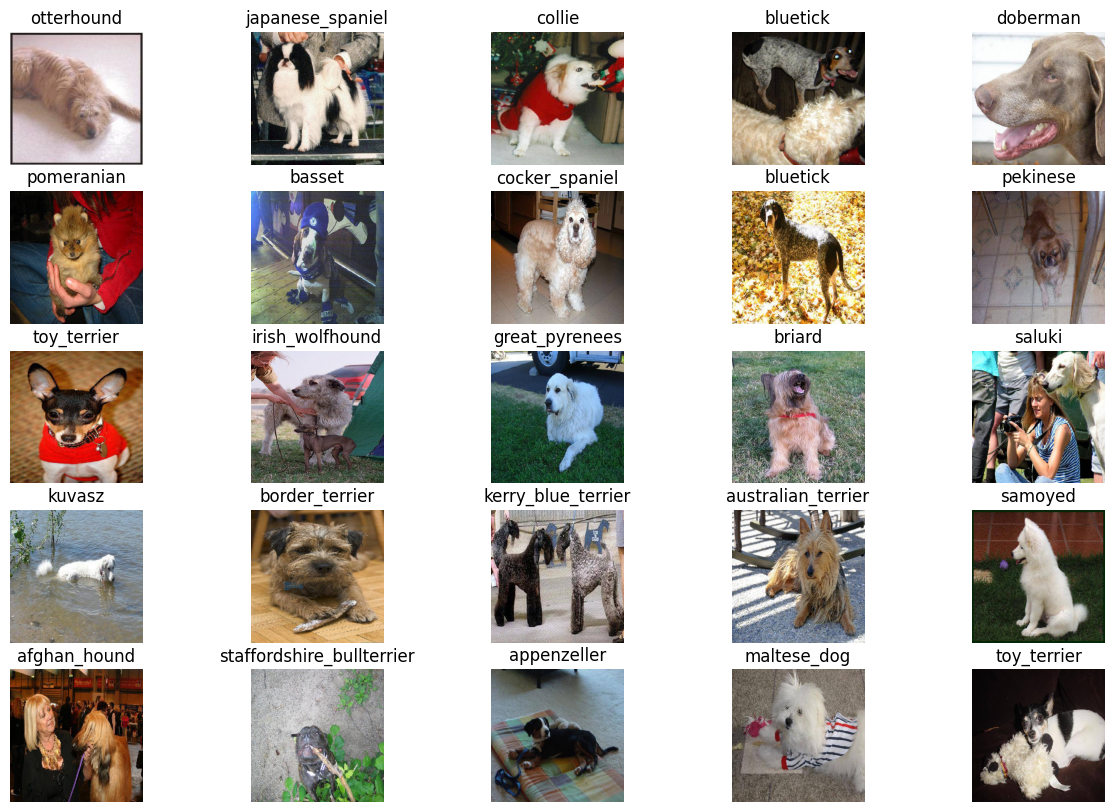

In [9]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)


## Define the base model

In [10]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

base_model.trainable=False

## Define the transfer model

In [11]:
# Build the model and pass an input with a defined shape 
# so the model can infer the shapes of all the layers
input_tensor = tf.keras.Input(shape=(331,331,3))
output_tensor = base_model(input_tensor)


In [12]:
# Now build the rest of the model
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

In [13]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for 
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_203 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [15]:
# A callback is an object that can perform actions at various stages of training 
# (for example, at the start or end of an epoch, before or after a single batch, etc).
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

## Train the transfer model to tune it

In [ ]:
# Fit the model by transfering the old weights to the new data scenario
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early])

#### The next 2 cells are used to persist and load the results
#### We don't want to lose any progress
### Note that the two save files have been loaded to web campus for you to use 

In [ ]:
# Persist the model for later use
# Use Keras for model and pickle for history
import pickle

# save the model
model.save("TransferModel_InceptionResNetV2.keras")

# save the history
with open('history.pkl', 'wb') as file: 
    # A new file will be created 
    pickle.dump(history, file) 

In [16]:
# This is how you load the objects of needed:

import pickle

# Load Model with Keras
persistedModel = keras.savings.load_model('TransferModel_InceptionResNetV2.keras')


AttributeError: module 'keras' has no attribute 'savings'

In [33]:
import h5py

# Assuming the file was saved in .h5 format
file_path = "TransferModel_InceptionResNetV2.keras"

with h5py.File(file_path, 'r') as f:
    # Check if 'keras_version' is available in the model's attributes
    if 'keras_version' in f.attrs:
        print(f.attrs['keras_version'])
    else:
        print("No Keras version found in model attributes")


2.10.0


In [ ]:
pip uninstall tensorflow


In [ ]:
pip install tensorflow==2.10.0


In [23]:

# Load history with pickle
with open('history.pkl', 'rb') as file: 
    # Call load method to deserialze 
    persistedHistory = pickle.load(file)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('TransferModel_InceptionResNetV2.keras')

# Optional: Print model summary
model.summary()


## Store and display the training history

In [19]:
# store results
acc = persistedHistory.history['accuracy']
val_acc = persistedHistory.history['val_accuracy']
loss = persistedHistory.history['loss']
val_loss = persistedHistory.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: \n          0.9182420969009399\nValidation Accuracy: 0.9042658805847168')

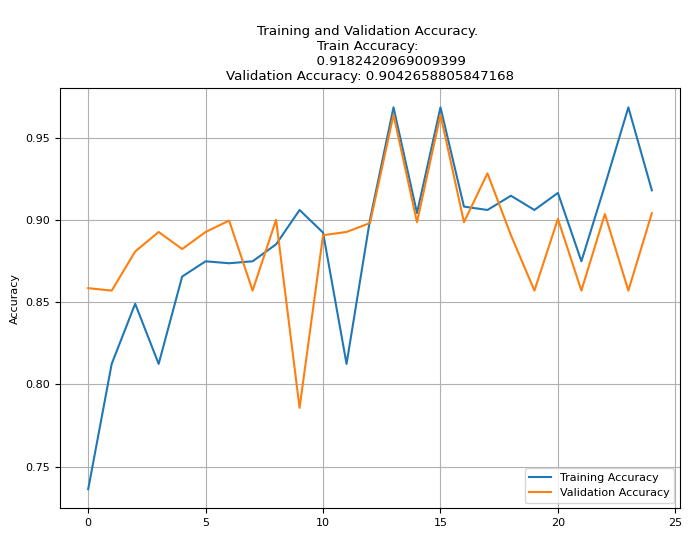

In [20]:
# plot results
# accuracy
plt.figure(figsize=(8, 12))
plt.rcParams['figure.figsize'] = [19,9]
plt.rcParams['font.size'] = 8
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f"""\nTraining and Validation Accuracy. \nTrain Accuracy: 
          {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}""")

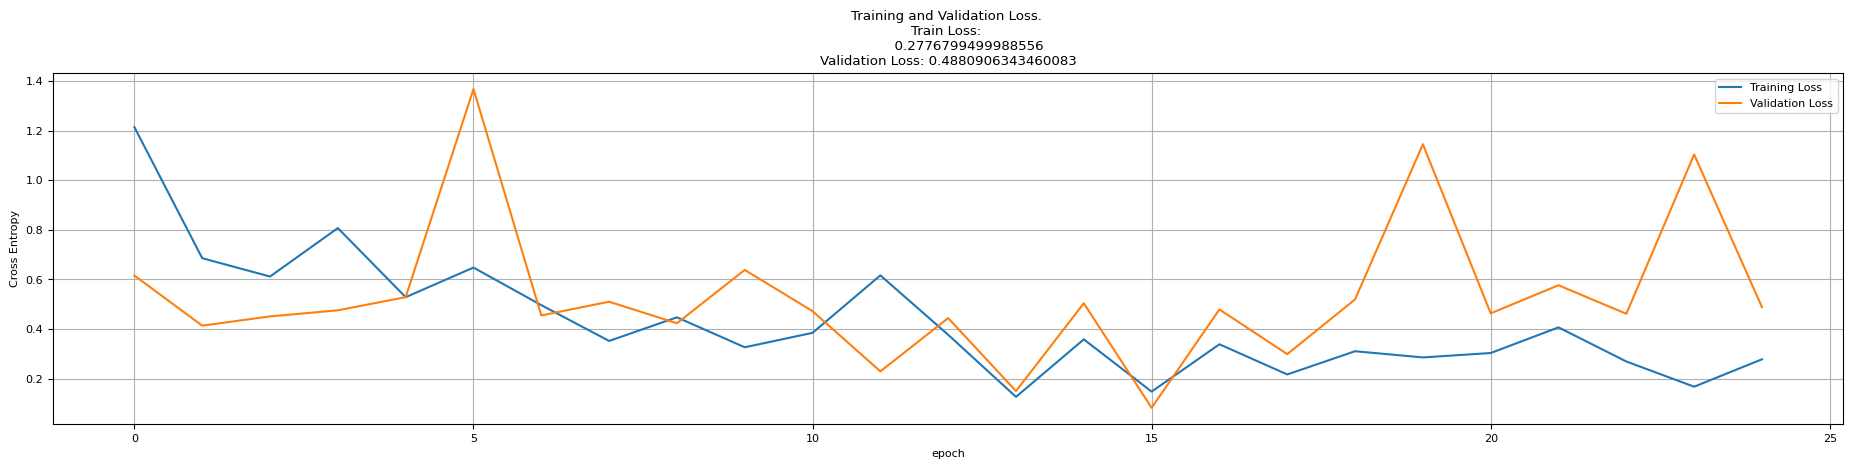

In [21]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f"""Training and Validation Loss. \nTrain Loss: 
          {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}""")
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

#### Validate the model using a batch of images from the validation set

In [22]:
accuracy_score = persistedModel.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 

print("Loss: ",accuracy_score[0])

NameError: name 'persistedModel' is not defined

## Load and classify a new image

In [ ]:
test_img_path = test_path+'/000621fb3cbb32d8935728e48679680e.jpg'

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [ ]:
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
img = tf.reshape(img, (-1, 331, 331, 3))
prediction = np.argmax(persistedModel.predict(img/255))

prediction